# Defining the visual vocabulary

In [1]:
import cv2 as cv
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import os
import sys

from sklearn.model_selection import train_test_split
from vocabulary import Vocabulary, open_image, draw_keypoints
from sklearn.preprocessing import label_binarize

In [2]:
dataset_dir = os.path.join('..', 'data')
dataset_limit = 100 # -> debug purposes

# Define classes for each image
img_class = []
with open('multiclass.csv') as img_classes:
    next(img_classes)
    img_class = sorted(map(lambda line: line.strip().split(','), img_classes.readlines()))

classes = [data[1] for data in img_class][:dataset_limit] # -> debug purposes
distinct_classes = list(dict.fromkeys(classes))
print(f'Distinct classes = {distinct_classes}')
binarized_classes = label_binarize(classes, classes=distinct_classes)
n_classes = binarized_classes.shape[1]

# Check classes correspondence
for i in range(len(classes)):
    print(binarized_classes[i], " - " + classes[i])

# Get relative paths for the images on the dataset directory
images = [os.path.join(dataset_dir, image) for image in sorted(os.listdir(dataset_dir))][:dataset_limit] # -> debug purposes
train_images, test_images, train_classes, test_classes = train_test_split(images, binarized_classes, test_size=0.33, random_state=42)

# Create vocabulary
n_words = 20

print(f'Creating vocabulary with {n_words} words')
sys.stdout.flush()
vocabulary = Vocabulary(n_words)

# Find keypoints for the vocabulary
vocabulary.train(train_images)

print(f'Vocabulary dimensions: {len(vocabulary.vocabulary.shape)}') 

Distinct classes = ['51', '13', '70', '25', '18', '42', '14', '29', '45', '44', '32']
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 0 1 0 0 0 0 0 0 0 0]  - 70
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 0 0 1 0 0 0 0 0 0 0]  - 25
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 0 0 1 0 0 0 0 0 0 0]  - 25
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 0 0 0 1 0 0 0 0 0 0]  - 18
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 0 0 0 0 1 0 0 0 0 0]  - 42
[1 0 0 0 0 0 0 0 0 0 0]  - 51
[0 1 0 0 0 0 0 0 0 0 0]  - 13
[0 1 0 0 0 0 0

# Training the Bag of Words vocabulary

In [3]:
# Perform Vector Quantization to represent the histogram of features as a vector
# Vector Quantization assigns codes from a code book to observations
from scipy.cluster.vq import vq

img_features = np.zeros((len(train_images), n_words), 'float32')
for i in range(len(train_images)):
    words, distance = vq(vocabulary.descriptor_list[i][1], vocabulary.vocabulary)
    for word in words:
        img_features[i][word] += 1

In [4]:
# Scale the words (normalization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(img_features)
img_features = scaler.transform(img_features)

In [5]:
from sklearn.multiclass import OneVsRestClassifier

# Train Support Vector Classification model to discriminate vectors
from sklearn.svm import LinearSVC
svc = OneVsRestClassifier(LinearSVC(max_iter=50000)) # 50000 iterations for better odds of converging
svc.fit(img_features, np.array(train_classes))

C:\Python39\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label not 10 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=LinearSVC(max_iter=50000))

# Validating Bag of Words model

In [6]:
print(f'Creating vocabulary with {n_words} words')
sys.stdout.flush()
test_vocabulary = Vocabulary(n_words)

# Find keypoints for the test vocabulary
test_vocabulary.train_without_clustering(test_images)

Creating vocabulary with 20 words
100%|██████████| 33/33 [00:01<00:00, 23.89it/s]


In [7]:
# Perform Vector Quantization to represent the histogram of features as a vector
# Vector Quantization assigns codes from a code book to observations
test_img_features = np.zeros((len(test_images), n_words), 'float32')
for i in range(len(test_images)):
    words, distance = vq(test_vocabulary.descriptor_list[i][1], vocabulary.vocabulary)
    for word in words:
        test_img_features[i][word] += 1

In [8]:
# Scale the words (normalization)
test_img_features = scaler.transform(test_img_features)
test_score = svc.decision_function(test_img_features)

In [9]:
# Perform predictions
predictions = svc.predict(test_img_features)

# Metrics

## Precision-Recall Curve

In [10]:
# Precision-Recall Curve
import matplotlib.pyplot as plt
import math
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_classes[:, i], test_score[:, i])
    average_precision[i] = average_precision_score(test_classes[:, i], test_score[:, i])
    if (math.isnan(average_precision[i])): 
        average_precision[i] = 0
        continue
    print('Average precision score for class ' + distinct_classes[i] + ': {0:0.2f}'.format(average_precision[i]))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(test_classes.ravel(), test_score.ravel())
average_precision["micro"] = average_precision_score(test_classes, test_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score for class 51: 0.39
Average precision score for class 13: 0.77
Average precision score for class 25: 0.14
Average precision score for class 29: 0.20
Average precision score for class 32: 0.03
Average precision score, micro-averaged over all classes: 0.40
C:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Python39\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.40')

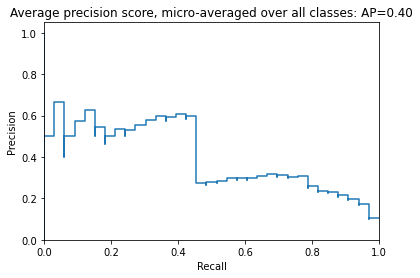

In [11]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

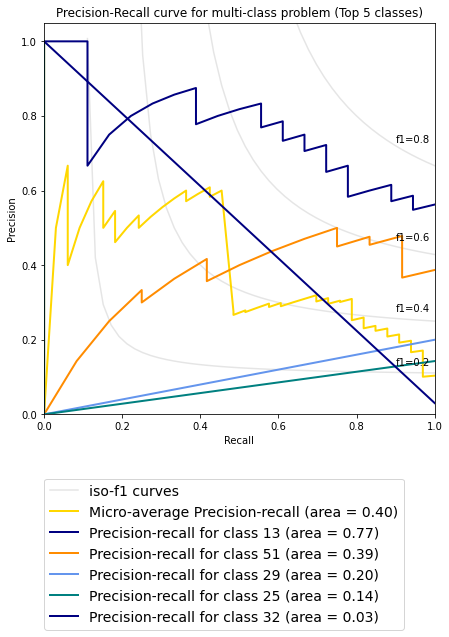

In [12]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

average_precision = {k: v for k, v in sorted(average_precision.items(), key=lambda item: -item[1])}

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('Micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

i = 0
for class_name, color in zip(average_precision, colors):
    if i == 5:
        break
    if average_precision[class_name] == 0 or class_name == 'micro':
        continue
    l, = plt.plot(recall[class_name], precision[class_name], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(distinct_classes[class_name], average_precision[class_name]))
    i += 1

fig = plt.gcf()
fig.subplots_adjust(bottom=0.2)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for multi-class problem (Top 5 classes)')
plt.legend(lines, labels, loc=(0, -0.11*i), prop=dict(size=14))


plt.show()